# Modelos Theta y 4Theta

# Modelos Theta

In [1]:
# 
import os, sys
from google.colab import drive
drive.mount('/content/mnt', force_remount=True)
nb_path = '/content/notebooks'
os.symlink('/content/mnt/My Drive/Colab Notebooks/Librerias', nb_path)
#sys.path.insert(0, nb_path)  # or append(nb_path)
sys.path.append(nb_path)  # or append(nb_path)

Mounted at /content/mnt


In [2]:
import warnings
warnings.filterwarnings('ignore')

Es necesario tener instalado DARTS

[Darts: https://unit8co.github.io/darts/index.html](https://unit8co.github.io/darts/index.html)


In [ ]:
#!pip install darts

In [3]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

- Utilizamos la libreria **darts**
- Seleccionamos los datos de Lineas aereas

In [4]:
# %%
from darts import TimeSeries
from darts.datasets import AirPassengersDataset


- **Grafico de la Serie Temporal de lineas aereas**



In [5]:

# %%
series = AirPassengersDataset().load()
series


<TimeSeries (DataArray) (Month: 144, component: 1, sample: 1)>
array([[[112.]],

       [[118.]],

       [[132.]],

       [[129.]],

       [[121.]],

       [[135.]],

       [[148.]],

       [[148.]],

       [[136.]],

       [[119.]],

...

       [[419.]],

       [[461.]],

       [[472.]],

       [[535.]],

       [[622.]],

       [[606.]],

       [[508.]],

       [[461.]],

       [[390.]],

       [[432.]]])
Coordinates:
  * Month      (Month) datetime64[ns] 1949-01-01 1949-02-01 ... 1960-12-01
  * component  (component) object '#Passengers'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

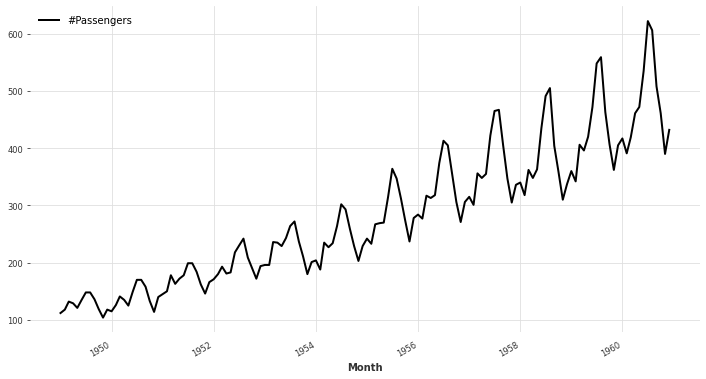

In [6]:
#import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)
series.plot()

- Diferentes formas de seleccionat TRAIN y TEST



```
split_before
```



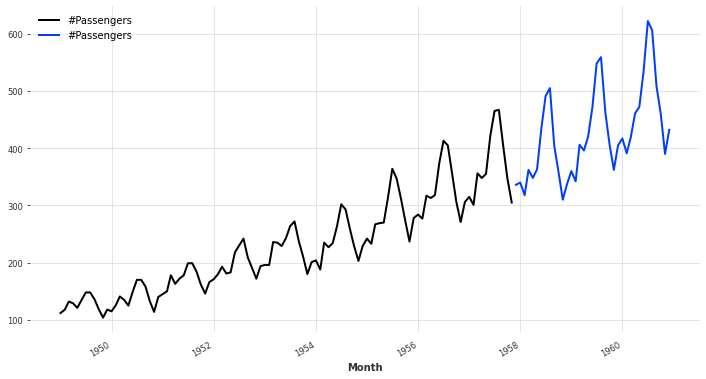

In [6]:
# %%
series1, series2 = series.split_before(0.75)
series1.plot()
series2.plot()



- Con el número de observaciones

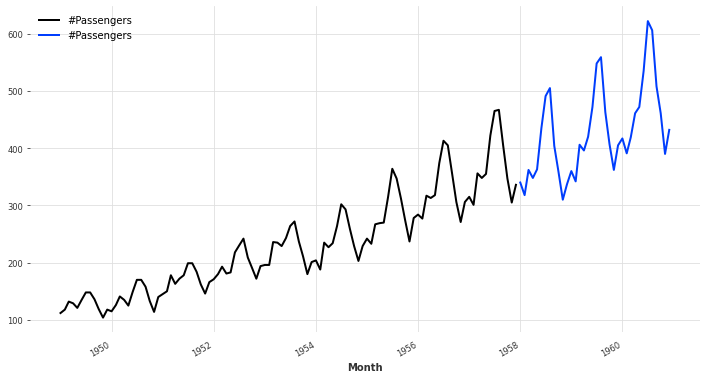

In [7]:

# %%
series1, series2 = series[:-36], series[-36:]
series1.plot()
series2.plot()


Con la fecha

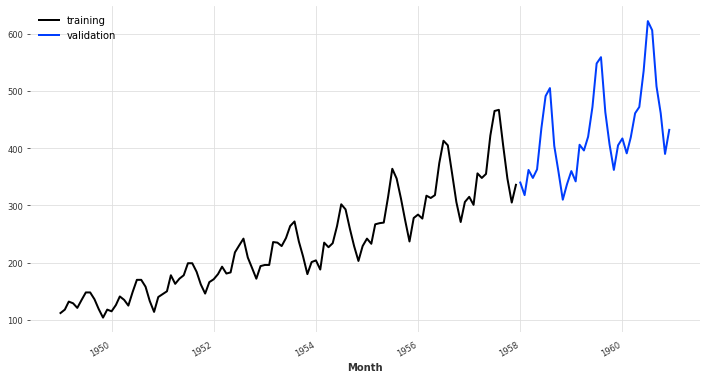

In [7]:

# %%
train, val = series.split_before(pd.Timestamp("19580101"))
train.plot(label="training")
val.plot(label="validation")



Comenzamos con el modelo THETA

In [8]:

# %%
from darts.models import Theta, FourTheta
from darts.metrics import mape

model =Theta(seasonality_period=12) # Supone Theta 2
model.fit(train)
forecast = model.predict(len(val))
print("model {} obtains MAPE: {:.2f}%".format(model, mape(val, forecast)))




model Theta(2) obtains MAPE: 8.15%


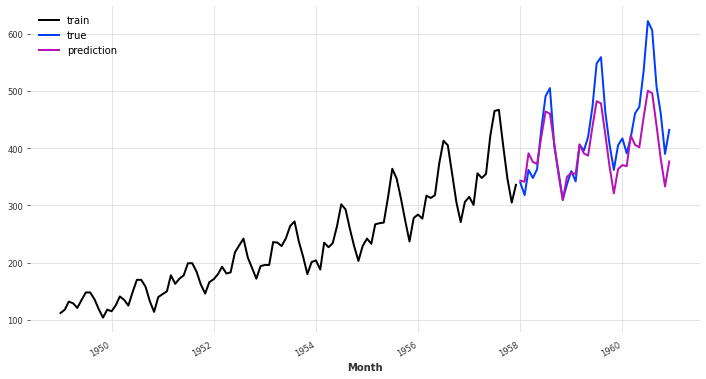

In [9]:
# %%
train.plot(label="train")
val.plot(label="true")
forecast.plot(label="prediction")

In [10]:

# %%
# Search for the best theta parameter, by trying 50 different values
thetas = 2- np.linspace(-10, 10, 50)

best_mape = float("inf")
best_theta = 0




for theta in thetas:

    model = Theta(theta)
    model.fit(train)
    pred_theta = model.predict(len(val))
    res = mape(val, pred_theta)

    if res < best_mape:
        best_mape = res
        best_theta = theta


In [11]:
thetas

array([12.        , 11.59183673, 11.18367347, 10.7755102 , 10.36734694,
        9.95918367,  9.55102041,  9.14285714,  8.73469388,  8.32653061,
        7.91836735,  7.51020408,  7.10204082,  6.69387755,  6.28571429,
        5.87755102,  5.46938776,  5.06122449,  4.65306122,  4.24489796,
        3.83673469,  3.42857143,  3.02040816,  2.6122449 ,  2.20408163,
        1.79591837,  1.3877551 ,  0.97959184,  0.57142857,  0.16326531,
       -0.24489796, -0.65306122, -1.06122449, -1.46938776, -1.87755102,
       -2.28571429, -2.69387755, -3.10204082, -3.51020408, -3.91836735,
       -4.32653061, -4.73469388, -5.14285714, -5.55102041, -5.95918367,
       -6.36734694, -6.7755102 , -7.18367347, -7.59183673, -8.        ])

In [12]:
best_theta

-3.5102040816326543

In [13]:

# %%
best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred_best_theta = best_theta_model.predict(len(val))

print(
    "The MAPE is: {:.2f}, with theta = {}.".format(
        mape(val, pred_best_theta), best_theta
    )
)


The MAPE is: 4.40, with theta = -3.5102040816326543.


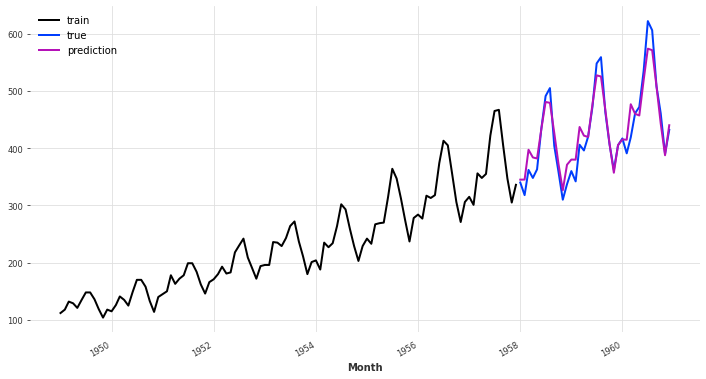

In [14]:
# %%
train.plot(label="train")
val.plot(label="true")
pred_best_theta.plot(label="prediction")

In [15]:
best_theta_model.model_params

OrderedDict([('theta', -3.5102040816326543),
             ('seasonality_period', None),
             ('season_mode',
              <SeasonalityMode.MULTIPLICATIVE: 'multiplicative'>)])

# Modelo 4Theta

In [16]:

model =FourTheta(seasonality_period=12)
model.fit(train)
forecast = model.predict(len(val))
print("model {} obtains MAPE: {:.2f}%".format(model, mape(val, forecast)))




model 4Theta(theta:2, curve:TrendMode.LINEAR, model:ModelMode.ADDITIVE, seasonality:SeasonalityMode.MULTIPLICATIVE) obtains MAPE: 8.08%


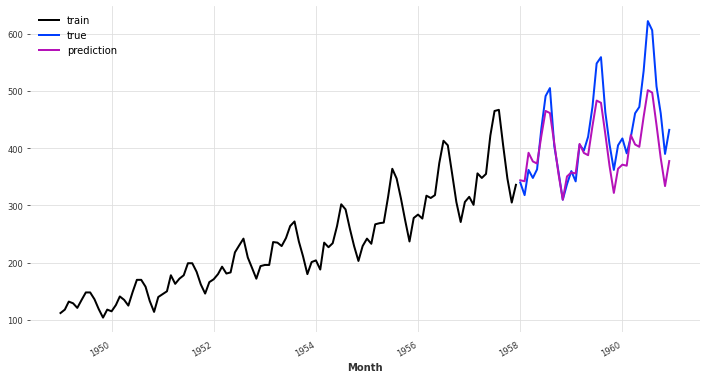

In [17]:
# %%
train.plot(label="train")
val.plot(label="true")
forecast.plot(label="prediction")

In [ ]:
from darts.utils.utils import SeasonalityMode, TrendMode, ModelMode
theta_grid = {
    #'theta':2- np.linspace(-10, 10, 10),
    'theta':[-4,-3,-2,-1,1,2,3,4],
    'model_mode': [ModelMode.ADDITIVE,ModelMode.MULTIPLICATIVE],
    'season_mode': [SeasonalityMode.MULTIPLICATIVE,SeasonalityMode.ADDITIVE],
    'trend_mode': [TrendMode.EXPONENTIAL,TrendMode.LINEAR]
}

best_grid_model=FourTheta.gridsearch(parameters=theta_grid,
                                series=train,
                                forecast_horizon=36, # 12
                                start=0.5,
                                last_points_only=False,
                                metric=mape,
                                reduction=np.mean,
                                verbose=True,
                                n_jobs=-1)

best_grid_model

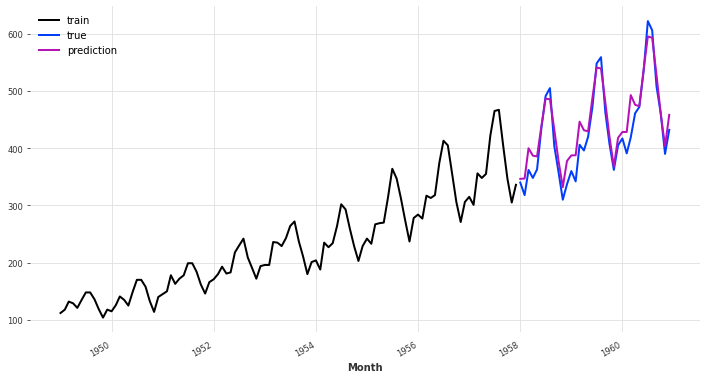

In [20]:
modelo=FourTheta(theta=best_grid_model[1]['theta'],
                 model_mode=ModelMode.ADDITIVE,
                 season_mode=SeasonalityMode.MULTIPLICATIVE,
                 trend_mode=TrendMode.LINEAR
                 )
modelo.fit(train)
pred_modelo = modelo.predict(len(val))

train.plot(label="train")
val.plot(label="true")
pred_modelo.plot(label="prediction")

In [21]:
print("model {} obtains MAPE: {:.2f}%".format(modelo, mape(val, pred_modelo)))

model 4Theta(theta:-2, curve:TrendMode.LINEAR, model:ModelMode.ADDITIVE, seasonality:SeasonalityMode.MULTIPLICATIVE) obtains MAPE: 5.33%


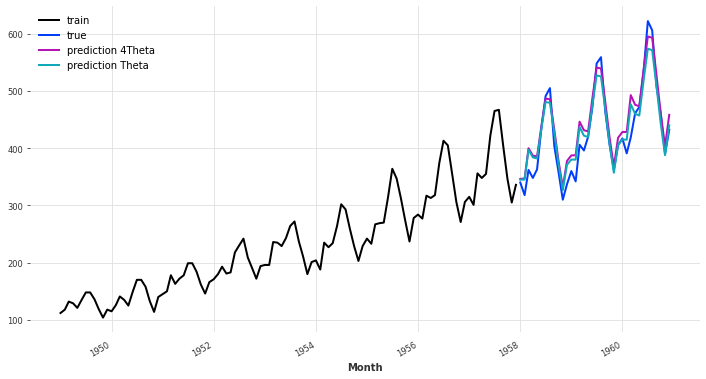

In [22]:

# %%
train.plot(label="train")
val.plot(label="true")
pred_modelo.plot(label="prediction 4Theta")
pred_best_theta.plot(label="prediction Theta")


# Cross Validation: Historical


100%|██████████| 38/38 [00:01<00:00, 30.16it/s]


MAPE = 4.68%


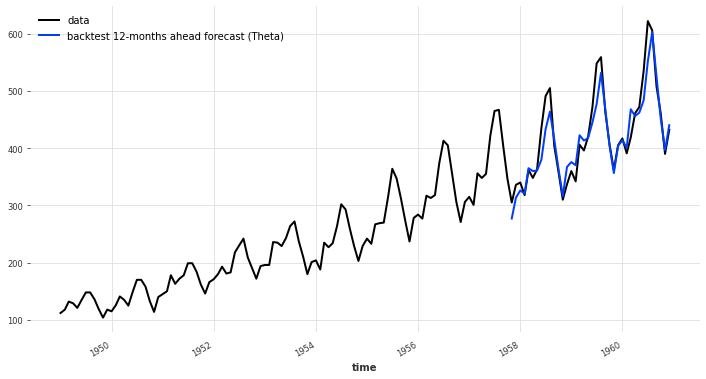

In [26]:


# %%
historical_fcast_theta = best_theta_model.historical_forecasts(
    series, start=0.5, forecast_horizon=36, verbose=True, stride=1
)

series.plot(label="data")
historical_fcast_theta.plot(label="backtest 12-months ahead forecast (Theta)")
print("MAPE = {:.2f}%".format(mape(historical_fcast_theta, series)))




## BackTest


100%|██████████| 76/76 [00:02<00:00, 31.19it/s]


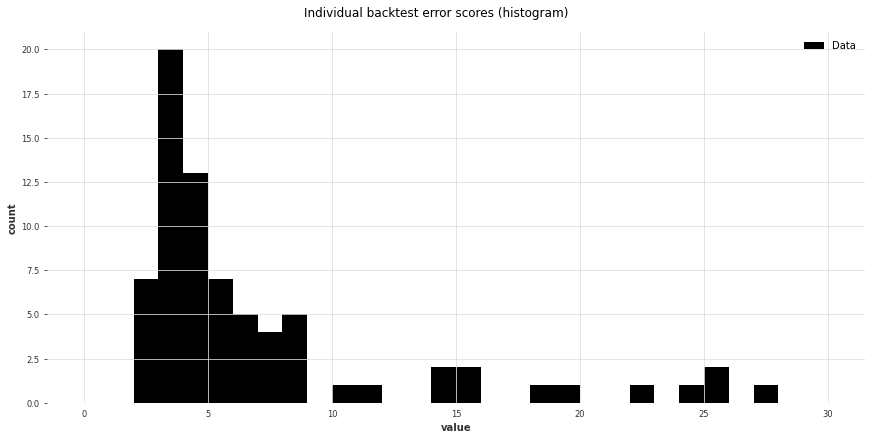

In [27]:

# %%


raw_errors = best_theta_model.backtest(
    series, 
    start=0.4, 
    forecast_horizon=12, 
    metric=mape, 
    reduction=None, # None: return errors
    verbose=True
)

from darts.utils.statistics import plot_hist

plot_hist(
    raw_errors,
    bins=np.arange(0, max(raw_errors), 1),
    title="Individual backtest error scores (histogram)",
)



In [28]:

# %%
average_error = best_theta_model.backtest(
    series,
    start=0.4,
    forecast_horizon=12,
    metric=mape,
    reduction=np.mean,  # this is actually the default
    verbose=True,
)

print("Average error (MAPE) over all historical forecasts: %.2f" % average_error)





100%|██████████| 76/76 [00:02<00:00, 30.71it/s]


Average error (MAPE) over all historical forecasts: 7.83


In [29]:
average_error

7.827396324361945

In [30]:
raw_errors

[6.5379281293155085,
 7.371185893726702,
 5.580456386627105,
 3.490243073743589,
 3.345177907426801,
 8.081784512441583,
 4.587132580556616,
 3.913350154796443,
 10.64311258201373,
 14.46239422675941,
 25.231383723542667,
 3.096056186912415,
 4.035816329953417,
 4.59003619858021,
 4.529220243680979,
 5.633325855935139,
 4.439711495777617,
 6.908807183605649,
 8.152361332114221,
 8.776733492845285,
 4.275579447393355,
 15.093990533025895,
 24.811885189555998,
 2.455907193212323,
 2.664453206416677,
 2.7038378913267826,
 3.3378249776294453,
 2.3710841239596046,
 2.314529926726536,
 3.5400688480895544,
 3.970323494455949,
 2.7213230520526084,
 11.273063780154619,
 18.23885243201152,
 25.775234541143515,
 4.001318302642196,
 3.272563039503778,
 3.1989832455968785,
 3.23415870671536,
 3.377634084916345,
 3.393203507664364,
 5.5747721835296495,
 4.897451839485512,
 5.359640162236314,
 14.328571189065908,
 22.12210672472015,
 30.805588003819274,
 8.758206148864014,
 7.050796871401413,
 6.1186